In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import graphviz

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv(r'C:\Users\mattp\Documents\Python\Titanic\train.csv')
df_test = pd.read_csv(r'C:\Users\mattp\Documents\Python\Titanic\test.csv')

# Clean the data

In [3]:
df.Cabin.fillna(' ', inplace = True)
df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
df.CabinTemp.value_counts()

     687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinTemp, dtype: int64

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinTemp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,


In [5]:
# Pull the titles out
df['Surname'] = df.Name.apply(lambda x: x.split(',')[0])
df['TempName'] = df.Name.apply(lambda x: (x.split(',')[1]).strip())
df['Title'] = df.TempName.apply(lambda x: x.split('.')[0])
df['FirstNames'] = df.TempName.apply(lambda x: (x.split('.')[1]).strip())
df = df.drop(columns={'Name','TempName'})

def consolidate_titles(title,sex):
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'the Countess', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if sex == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df['Title'] = df.apply(lambda x: consolidate_titles(x['Title'],x['Sex']), axis = 1)
title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4} 
df['Title'] = df['Title'].map(title_mapping)
# We have male as 1 & 2 and female as 3 & 4 so if there is a split by gender this should be picked up

In [6]:
# Split the ages based on df.Age.describe()
df.Age.fillna(df.Age.mean(), inplace=True) # take the mean age
def split_ages(age):
    if age < 16:
        return 0
    elif age < 30:
        return 1
    elif age < 45:
        return 2
    elif age < 60:
        return 3
    else:
        return 4
df['Age'] = df['Age'].apply(split_ages)

In [7]:
# Split the fares based on df.Fare.describe()
def split_fares(fare):
    if fare < 7.9:
        return 0
    elif fare < 14.5:
        return 1
    elif fare <31.0:
        return 2
    else:
        return 3
df['Fare'] = df['Fare'].apply(split_fares)

In [8]:
# Check if person is alone
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Alone'] = df.FamilySize.apply(lambda x: 1 if x == 1 else 0)

# Remove blanks (S is the most common)
df.Embarked.fillna('S', inplace=True)

# Remap non numerical fields
df['Sex'] = df['Sex'].map({'male':0,'female':1}).astype(int)
# Sex mapped the same as Title (male lower value, female higher value)
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# One Hot Encoding for this one?

In [9]:
# Too many cabins to have a different variable for each, so just check if passengers have a cabin at all
df.Cabin.fillna(' ', inplace = True)
df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
df.CabinTemp.value_counts()
df['Cabin'] = 0 
df.loc[df['CabinTemp'] != ' ', 'Cabin'] = 1

In [10]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinTemp,Surname,Title,FirstNames,FamilySize,Alone
0,1,0,3,0,1,1,0,A/5 21171,0,0,0,,Braund,1,Owen Harris,2,0
1,2,1,1,1,2,1,0,PC 17599,3,1,1,C,Cumings,3,John Bradley (Florence Briggs Thayer),2,0
2,3,1,3,1,1,0,0,STON/O2. 3101282,1,0,0,,Heikkinen,4,Laina,1,1
3,4,1,1,1,2,1,0,113803,3,1,0,C,Futrelle,3,Jacques Heath (Lily May Peel),2,0
4,5,0,3,0,2,0,0,373450,1,0,0,,Allen,1,William Henry,1,1


In [11]:
df_tree = df.drop(columns = ['Ticket', 'CabinTemp', 'Surname', 'FirstNames', 'PassengerId'])
df_tree.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,Alone
0,0,3,0,1,1,0,0,0,0,1,2,0
1,1,1,1,2,1,0,3,1,1,3,2,0
2,1,3,1,1,0,0,1,0,0,4,1,1
3,1,1,1,2,1,0,3,1,0,3,2,0
4,0,3,0,2,0,0,1,0,0,1,1,1


## Sense check data before using decision trees

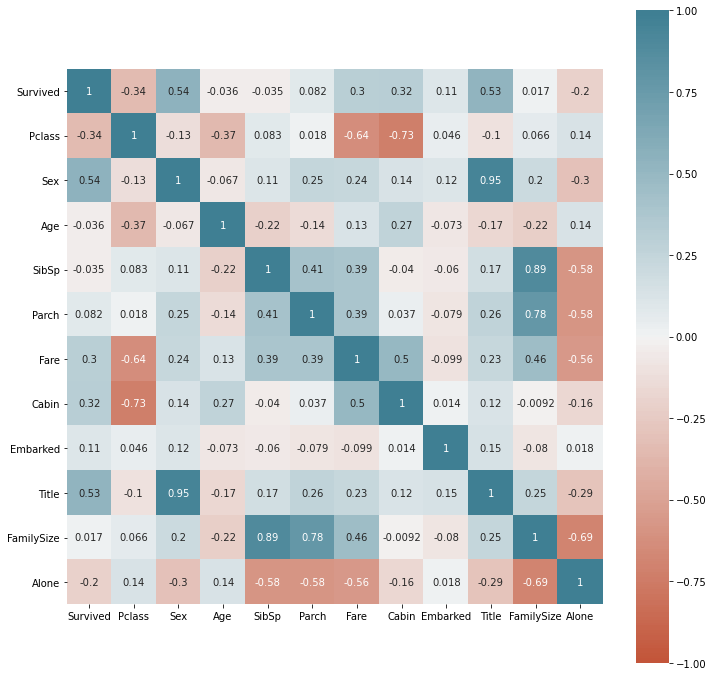

In [12]:
corr = df_tree.corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

- Sex & Title are heavily correlated but contain basically the same information. Lets use Title as it also factors in age.
- SibSp & Parch are both heavily correlated with Family Size. It isn't clear if its better to leave them in or not at the moment.

In [13]:
df_tree.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,Alone
0,0,3,0,1,1,0,0,0,0,1,2,0
1,1,1,1,2,1,0,3,1,1,3,2,0
2,1,3,1,1,0,0,1,0,0,4,1,1
3,1,1,1,2,1,0,3,1,0,3,2,0
4,0,3,0,2,0,0,1,0,0,1,1,1


Now that our dataset looks ready for modelling, lets begin!

In [14]:
# Split our dataset and target values
X, y = df_tree.iloc[:,1:],df_tree.iloc[:,0]

# Now we set up our training matrix in a form that can be used by XGBoost
titanic_train_dmatrix = xgb.DMatrix(data=X, label=y)

# Define our paramters to be used in the XGBoost model
params = {'objective':'binary:logistic', 'max_depth':2, 'booster':'gbtree', 'min_child_weight':10, 'eval_metric':'error', \
         'subsample':1, 'eta':0.3}

# Define the splits for our validation
folds = model_selection.KFold(n_splits=3, shuffle=True, random_state=123)

In [15]:
# Define a model to be used. Key points are that we are classifying on a binary decision, are setting a max depth of 2 trees
# and a learning rate of 0.3. As our dataset is on the smaller side, we will not be using subsample / colsample_bytree regularization.
model = xgb.XGBClassifier(objective = 'binary:logistic', params = params, n_estimators=5, verbosity = 0, use_label_encoder = False, \
                   seed = 123)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              params={'booster': 'gbtree', 'eta': 0.3, 'eval_metric': 'error',
                      'max_depth': 2, 'min_child_weight': 10,
                      'objective': 'binary:logistic', 'subsample': 1},
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, seed=123, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=0)

In [16]:
cv_results = xgb.cv(dtrain=titanic_train_dmatrix, params=params, folds=folds, num_boost_round=50, early_stopping_rounds = 10, \
                   as_pandas=True, seed = 123)

In [17]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.200898,0.008399,0.210999,0.020816
1,0.200898,0.008399,0.210999,0.020816
2,0.197531,0.010408,0.210999,0.020816
3,0.189113,0.017405,0.187430,0.012992
4,0.189114,0.016571,0.188552,0.012598
5,0.187991,0.020124,0.200898,0.015632
6,0.179012,0.008729,0.178451,0.015307


In [18]:
print('The accuracy for our model on is: ', round(1 - cv_results.iloc[-1,2],3)*100,'%',sep = '')

The accuracy for our model on is: 82.19999999999999%


In [19]:
%%capture
# Fit model so we can use the predictors and tree visualisations
model.fit(X,y)

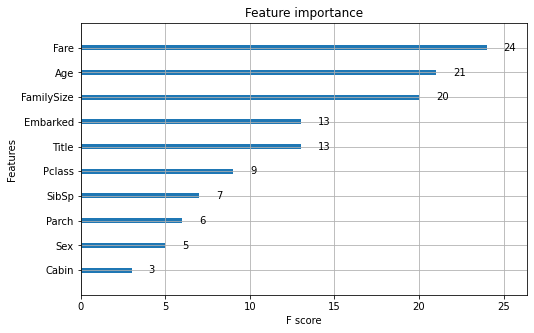

In [20]:
# Plot the most important features through the models we have created.
plt.rcParams['figure.figsize'] = [8,5]
plot_importance(model, max_num_features = 10)
plt.show()

Age is important but title doesn't come up as often
Only a count of the number of times each has apperated

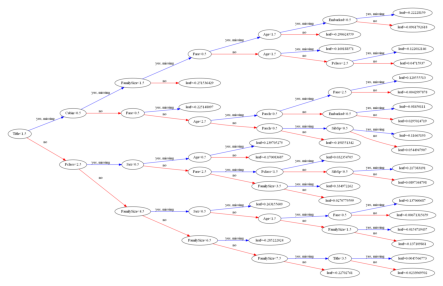

In [21]:
# Plot the final tree produced by the model
xgb.plot_tree(model,num_trees=4, rankdir='LR')
plt.rcParams['figure.figsize'] = [50,25]
plt.show()

## Create a function to clean our data in the same format as above

In [ ]:
def clean_data(df):
    df.Cabin.fillna(' ', inplace = True)
    df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
    
    # Pull the titles out
    df['Surname'] = df.Name.apply(lambda x: x.split(',')[0])
    df['TempName'] = df.Name.apply(lambda x: (x.split(',')[1]).strip())
    df['Title'] = df.TempName.apply(lambda x: x.split('.')[0])
    df['FirstNames'] = df.TempName.apply(lambda x: (x.split('.')[1]).strip())
    df = df.drop(columns={'Name','TempName'})
    
    df['Title'] = df.apply(lambda x: consolidate_titles(x['Title'],x['Sex']), axis = 1)
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4} 
    df['Title'] = df['Title'].map(title_mapping)
    # We have male as 1 & 2 and female as 3 & 4 so if there is a split by gender this should be picked up
    
    df['Age'] = df['Age'].apply(split_ages)
    
    df['Fare'] = df['Fare'].apply(split_fares)
    
    # Check if person is alone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Alone'] = df.FamilySize.apply(lambda x: 1 if x == 1 else 0)

    # Remove blanks (S is the most common and take mean age)
    df.Embarked.fillna('S', inplace=True)
    df.Age.fillna(df.Age.mean(), inplace=True)

    # Remap non numerical fields
    df['Sex'] = df['Sex'].map({'male':0,'female':1}).astype(int)
    # Sex mapped the same as Title (male lower value, female higher value)
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Too many cabins to have a different variable for each, so just check if passengers have a cabin at all
    df.Cabin.fillna(' ', inplace = True)
    df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
    df.CabinTemp.value_counts()
    df['Cabin'] = 0 
    df.loc[df['CabinTemp'] != ' ', 'Cabin'] = 1
    df = df.drop(columns = ['Ticket', 'CabinTemp', 'Surname', 'FirstNames', 'PassengerId'])
    return df


df_test_data = clean_data(df_test)

In [ ]:
df_test_data.head()

In [ ]:
%%capture
preds = model.predict(df_test_data)

In [ ]:
df_test['Survived'] = preds
df_preds = df_test.loc[:,['PassengerId','Survived']]

In [ ]:
df_preds.to_csv(r'C:\Users\mattp\Documents\Python\Titanic\predictions.csv')